## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install -U torch torchvision torchaudio

# # Install additional dependencies
# !pip install numpy pandas pillow timm

# # Install ONNX packages
# !pip install onnx onnxruntime onnx-simplifier

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import json
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file, get_source_code
from cjm_pil_utils.core import resize_img

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
from torch import nn

# Import ONNX dependencies
import onnx # Import the onnx module
from onnxsim import simplify # Import the method to simplify ONNX models
import onnxruntime as ort # Import the ONNX Runtime

## Setting Up the Project

### Set the Directory Paths

In [3]:
# The name for the project
project_name = f"pytorch-timm-image-classifier"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2024-02-02_15-41-23")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-timm-image-classifier
Checkpoint Directory:,pytorch-timm-image-classifier/2024-02-02_15-41-23


## Loading the Checkpoint Data

### Load the Class Labels

In [4]:
# The class labels path
class_labels_path = list(checkpoint_dir.glob('*classes.json'))[0]

# Load the JSON class labels data
with open(class_labels_path, 'r') as file:
        class_labels_json = json.load(file)

# Get the list of classes
class_names = class_labels_json['classes']

# Print the list of classes
pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


### Load the Model Checkpoint

In [5]:
# The model checkpoint path
checkpoint_path = list(checkpoint_dir.glob('*.pth'))[0]

# Load the model checkpoint onto the CPU
model_checkpoint = torch.load(checkpoint_path, map_location='cpu')

### Load the Finetuned Model

In [6]:
# Specify the model configuration
model_type = checkpoint_path.stem.split(".")[0]

# Create a model with the number of output classes equal to the number of class names
model = timm.create_model(model_type, num_classes=len(class_names))

# Initialize the model with the checkpoint parameters and buffers
model.load_state_dict(model_checkpoint)

<All keys matched successfully>

### Get the Normalization Stats

In [7]:
# Import the resnet module
from timm.models import resnet

# Get the default configuration of the chosen model
model_cfg = resnet.default_cfgs[model_type].default.to_dict()

# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

## Exporting the Model to ONNX

### Prepare the Model for Inference

#### Define model export wrapper

In [8]:
class InferenceWrapper(nn.Module):
    def __init__(self, model, normalize_mean, normalize_std, scale_inp=False, channels_last=False):
        super().__init__()
        self.model = model
        self.register_buffer("normalize_mean", normalize_mean)
        self.register_buffer("normalize_std", normalize_std)
        self.scale_inp = scale_inp
        self.channels_last = channels_last
        self.softmax = nn.Softmax(dim=1)

    def preprocess_input(self, x):
        if self.scale_inp:
            x = x / 255.0

        if self.channels_last:
            x = x.permute(0, 3, 1, 2)

        x = (x - self.normalize_mean) / self.normalize_std
        return x

    def forward(self, x):
        x = self.preprocess_input(x)
        x = self.model(x)
        x = self.softmax(x)
        return x

#### Wrap model with preprocessing and post-processing steps

In [9]:
# Define the normalization mean and standard deviation
mean_tensor = torch.tensor(norm_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(norm_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
model.eval();

# Wrap the model with preprocessing and post-processing steps
wrapped_model = InferenceWrapper(model, 
                                 mean_tensor, 
                                 std_tensor, 
                                 scale_inp=False, # Scale input values from the rang [0,255] to [0,1]
                                 channels_last=False, # Have the model expect input in channels-last format
                                )

### Prepare the Input Tensor

In [10]:
input_tensor = torch.randn(1, 3, 256, 256)

### Export the Model to ONNX

In [11]:
# Set a filename for the ONNX model
onnx_file_path = f"{checkpoint_dir}/{class_labels_path.stem.removesuffix('-classes')}-{model_type}.onnx"

# Export the PyTorch model to ONNX format
torch.onnx.export(wrapped_model.cpu(),
                  input_tensor.cpu(),
                  onnx_file_path,
                  export_params=True,
                  do_constant_folding=False,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

### Simplify the ONNX Model

In [12]:
# Load the ONNX model from the onnx_file_name
onnx_model = onnx.load(onnx_file_path)

# Simplify the model
model_simp, check = simplify(onnx_model)

# Save the simplified model to the onnx_file_name
onnx.save(model_simp, onnx_file_path)

## Performing Inference with ONNX Runtime

### Create an Inference Session

In [13]:
# Load the model and create an InferenceSession
session = ort.InferenceSession(onnx_file_path, providers=['CPUExecutionProvider'])

### Select a Test Image

The file ./pexels-elina-volkova-16191659.jpg already exists and overwrite is set to False.


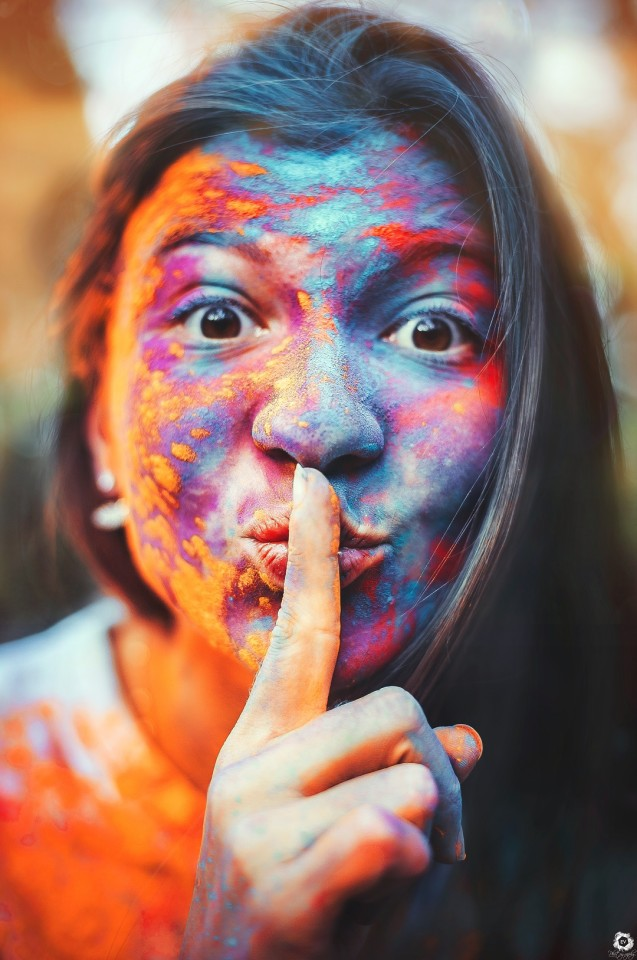

Test Image Size:,"(637, 960)"


In [14]:
test_img_name = 'pexels-elina-volkova-16191659.jpg'
test_img_url = f"https://huggingface.co/datasets/cj-mills/pexel-hand-gesture-test-images/resolve/main/{test_img_name}"

download_file(test_img_url, './', False)

test_img = Image.open(test_img_name)
display(test_img)

pd.Series({
    "Test Image Size:": test_img.size, 
}).to_frame().style.hide(axis='columns')

### Prepare the Test Image

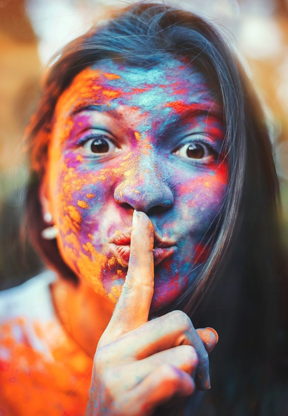

Input Image Size:,"(288, 416)"


In [15]:
# Set test image size
test_sz = 288

# Resize image without cropping to multiple of the max stride
input_img = resize_img(test_img.copy(), target_sz=test_sz)

display(input_img)

pd.Series({
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

### Prepare the Input Tensor

In [16]:
# Convert the existing input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

### Compute the Predictions

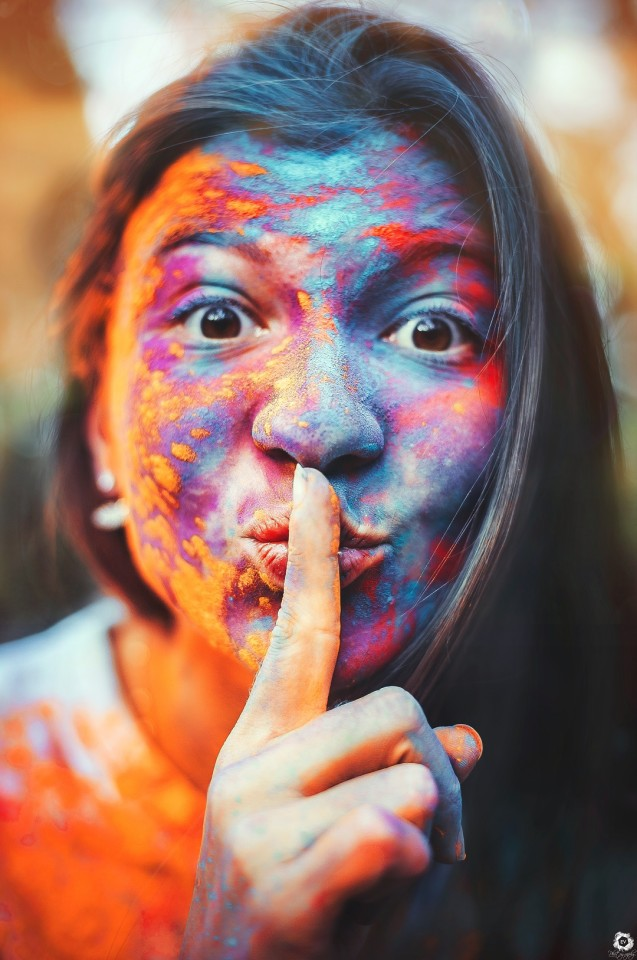

Input Size:,"(288, 416)"
Predicted Class:,mute
Confidence Score:,100.00%


In [17]:
# Run inference
outputs = session.run(None, {"input": input_tensor_np})[0]

# Get the highest confidence score
confidence_score = outputs.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[outputs.argmax()]

# Display the image
display(test_img)

# Store the prediction data in a Pandas Series for easy formatting
pd.Series({
    "Input Size:": input_img.size,
    "Predicted Class:": pred_class,
    "Confidence Score:": f"{confidence_score*100:.2f}%"
}).to_frame().style.hide(axis='columns')